## Google Colab Setup
Commands to mount data from drive to colab environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/My\ Drive/m5/*.pickle /content/

## Load Store Data
Load all of the data associated for the given store number

In [1]:
import pandas as pd
def load_store(store_id):
  """Loads from the project root directory"""
  return pd.read_pickle(f"./StoreID_{store_id}.pickle")

### Single Store Data
Read in DataFrame for store '0'

In [2]:
store_01_df = load_store('0')
store_01_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sold,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN


In [5]:
store_01_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5832737 entries, 2011-01-29 to 2016-04-24
Data columns (total 19 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       int16   
 2   dept_id       int8    
 3   cat_id        int8    
 4   store_id      int8    
 5   state_id      int8    
 6   sold          int16   
 7   wm_yr_wk      int16   
 8   wday          int8    
 9   month         int8    
 10  year          int16   
 11  event_name_1  int8    
 12  event_type_1  int8    
 13  event_name_2  int8    
 14  event_type_2  int8    
 15  snap_CA       int8    
 16  snap_TX       int8    
 17  snap_WI       int8    
 18  sell_price    float16 
dtypes: category(1), float16(1), int16(4), int8(13)
memory usage: 185.0 MB


### Combined Dataset

In [27]:
df = load_store(0)
# for idx in range(1, 10):
#     df = pd.concat([df, load_store(idx)])

In [28]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,sold,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
2011-01-29,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,11101,1,1,2011,30,4,4,2,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,FOODS_3_823_CA_1_validation,1432,2,0,0,0,1,11613,2,4,2016,30,4,4,2,0,0,0,2.980469
2016-04-24,FOODS_3_824_CA_1_validation,1433,2,0,0,0,0,11613,2,4,2016,30,4,4,2,0,0,0,2.480469
2016-04-24,FOODS_3_825_CA_1_validation,1434,2,0,0,0,2,11613,2,4,2016,30,4,4,2,0,0,0,3.980469


## Feature Engineering
Starter features from https://www.kaggle.com/ragnar123/very-fst-model

### Time Features

In [15]:
def demand_fe(data):
    # rolling demand features
    data['lag_t28'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(30).std())
    data['rolling_skew_t30'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(30).skew())
    data['rolling_kurt_t30'] = data.groupby(['id'])['sold'].transform(lambda x: x.shift(28).rolling(30).kurt())
    return data

### Price Features

In [16]:
def price_fe(data):
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    return data

## Data Preprocessing
Get our dataset into a format the models will be able to use

In [17]:
df.isna().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
sold                  0
wm_yr_wk              0
wday                  0
month                 0
year                  0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      1129842
dtype: int64

In [29]:
df['sell_price'] = df['sell_price'].fillna(-1)

In [31]:
import numpy as np
from sklearn.preprocessing import StandardScaler


df = demand_fe(df)
df = price_fe(df)
to_drop = ['sold']

targets = df['2014-04-25':'2016-04-24']['sold']
data = df['2014-04-25':'2016-04-24']

X_train = data['2014-04-25':'2016-03-27'].drop(to_drop, axis=1).select_dtypes(include='number').to_numpy()
y_train = targets['2014-04-25':'2016-03-27'].to_numpy()
X_val = data['2016-04-24':].drop(to_drop, axis=1).select_dtypes(include='number').to_numpy()
y_val = targets['2016-04-24':].to_numpy()

del df
del data
del targets

In [32]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

## NN Model
Instantiate, create, and compile a basic Dense model for testing.



In [21]:
from keras.models import Sequential 
from keras import layers 
from keras.optimizers import RMSprop

def get_model():
    model = Sequential() 
    model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1], )))  
    model.add(layers.Dense(75, activation='relu'))  
    model.add(layers.Dense(10, activation='relu'))  
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse') 
    return model

### Example

In [40]:
y_train

array([0, 1, 0, ..., 1, 4, 5], dtype=int16)

In [22]:
model = get_model()
history = model.fit(X_train, 
                    y_train, 
                    # batch_size=10000,
                    # shuffle=True,
                    # steps_per_epoch=len(y_train)//2000,
                    epochs=30, 
                    validation_data=(X_val, y_val),
                    # validation_steps=len(y_test)//200
                    )

Train on 2143447 samples, validate on 3049 samples
Epoch 1/30
2143447/2143447 [==============================] - 201s 94us/step - loss: 14.1802 - val_loss: 16.6116
Epoch 2/30
2143447/2143447 [==============================] - 203s 95us/step - loss: 14.1776 - val_loss: 16.5014
Epoch 3/30
2143447/2143447 [==============================] - 202s 94us/step - loss: 14.1764 - val_loss: 16.5684
Epoch 4/30
 138336/2143447 [>.............................] - ETA: 3:15 - loss: 13.7150

KeyboardInterrupt: ignored

In [16]:
import matplotlib.pyplot as plt

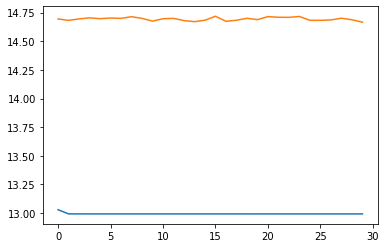

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## LGBM Model
The NN model is not fitting to our data. 

We will try a LGBM model and see if it has better luck

In [33]:
import lightgbm as lgbm

In [43]:
train_lgbm = lgbm.Dataset(X_train, y_train)
val_lgbm = lgbm.Dataset(X_val, y_val)

In [35]:
params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                }


### Example

In [36]:
from sklearn import metrics
model = lgbm.train(params, 
                   train_lgbm, 
                   num_boost_round = 2500, 
                   early_stopping_rounds = 50, 
                   valid_sets = [train_lgbm, val_lgbm], 
                   verbose_eval = 100)

val_pred = model.predict(X_val)
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
print(f'Our val rmse score is {val_score}')

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 2.54493	valid_1's rmse: 2.34775
[200]	training's rmse: 2.46707	valid_1's rmse: 2.30089
Early stopping, best iteration is:
[164]	training's rmse: 2.4901	valid_1's rmse: 2.29879
Our val rmse score is 2.298788720025924


### Hyperparam Tuning

In [37]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [38]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

In [39]:
clf = lgbm.LGBMRegressor(max_depth=-1,
                         random_state=236, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=-1, 
                         n_estimators=5000)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='neg_root_mean_squared_error',
    cv=3,
    refit=True,
    random_state=236,
    verbose=True)

In [45]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(val_lgbm.data, val_lgbm.label)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
gs.fit(train_lgbm.data, train_lgbm.label, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
# Best score reached: -2.493945295968725 with params: {'colsample_bytree': 0.6761597976790243, 'min_child_samples': 281, 'min_child_weight': 100.0, 'num_leaves': 11, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.2970194609775752} 

In [49]:
gs.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6761597976790243, importance_type='split',
              learning_rate=0.1, max_depth=-1, metric='rmse',
              min_child_samples=281, min_child_weight=100.0, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=11, objective=None,
              random_state=236, reg_alpha=0, reg_lambda=0, silent=True,
              subsample=0.2970194609775752, subsample_for_bin=200000,
              subsample_freq=0)

In [48]:
save_model(gs.best_estimator_, f'/content/drive/My Drive/m5/CA_0_229.r')

## Save Model
Save model to disk, used by the logger to create checkpoints. 

Important because we will be running many notebook kernels in parallel.

In [47]:
import pickle

def save_model(model, fname):
    """Serialize model using given filename
    Args: 
        model (serializeable): Model to save
        fname (str): File name
    Returns:
        None  
    """
    pickle.dump(model, open(fname, 'wb'))

## WRMSSE Scoring
The M5 uses a unique scoring function that incorporates weights of the last 28 days of the series.

These functions are from the [WRMSSE Evaluator with extra features](https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features) notebook.


In [ ]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

### Example
Load in our data, create a fake predictions array to pass in and make sure we are getting a score back.

In [ ]:
!cp /content/drive/My\ Drive/m5/m5-forecasting-accuracy.zip /content

In [ ]:
!unzip /content/m5-forecasting-accuracy.zip

In [ ]:
%%time

train_df = pd.read_csv('./sales_train_validation.csv')
calendar = pd.read_csv('./calendar.csv')
prices = pd.read_csv('./sell_prices.csv')

train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:].copy()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
del train_fold_df, train_df, calendar, prices

In [ ]:
valid_fold_df

In [ ]:
valid_preds = np.random.randint(4, size=valid_fold_df.shape)
e.score(valid_preds)

## Build Submission
Take predictions and unmelt them so they are back in wide form.

In [ ]:
# TODO

## Model Log
Save a pickle of the model and enter the details into the log.

In [ ]:
from datetime import datetime
import os

def log_model(model, score, model_name, description):
    """Save model and create an entry in 'model_log.log'
    Args: 
        model (can predict): Model to score and save
        model_name (str): Name to associate with model
        description (str): Any special information to associated with model
    Returns:
        None
    """
    timestamp = datetime.now()

    path = f'./{model_name}'
    fname = f'{path}/{timestamp.date()}-{timestamp.time()}-{score}.pickle'
    
    try:
      os.listdir(path)
    except:
      os.mkdir(path)
    
    save_model(model, fname)
    
    with open(f'./{model_name}/model_log.log', 'a') as log:
        entry = f"{timestamp}, {description}, {score}, {fname}\n"
        log.write(entry)

### Example
We will load the iris dataset into a stock logistic regression model from sklearn.

Then we can fit it and score its predictions before we try to log it. 

The log function will pickle the model and write an entry to our log data frame.

In [ ]:
from sklearn import datasets
test_data = datasets.load_iris()

In [ ]:
X = test_data.data 
y = test_data.target

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)
score = model.score(X, y)

In [ ]:
log_model(model, score, 'logistic_regression', 'score works')

In [ ]:
import pandas as pd
log_df = pd.read_csv('./logistic_regression/model_log.log', names=['timestamp', 'description', 'score', 'filename'])

In [ ]:
log_df.head()